In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [10]:
def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))

    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Remove top/right borders and set linewidth
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [11]:
class LinearAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Define separate Q, K, and V for each head explicitly
        self.W_Q = nn.Parameter(torch.randn(num_heads, self.head_dim, embed_dim))
        self.W_K = nn.Parameter(torch.randn(num_heads, self.head_dim, embed_dim))
        self.W_V = nn.Parameter(torch.randn(num_heads, embed_dim, embed_dim).abs())

    def forward(self, X):
        """
        X: Tensor of shape [batch_size, seq_len, embed_dim]
        """
        batch_size, embed_dim, seq_len = X.shape
        N = seq_len

        output = X.clone()  # Residual connection

        for i in range(self.num_heads):
            # Compute Q, K, V
            Q = self.W_Q[i] @ X  # [batch_size, embed_dim, seq_len]
            K = self.W_K[i] @ X  # [batch_size, embed_dim, seq_len]
            V = self.W_V[i] @ X  # [batch_size, embed_dim, seq_len]

            # Attention scores (batch_size x seq_len x seq_len)
            scores = torch.bmm(K.transpose(1, 2), Q)  # [batch_size, seq_len, seq_len]

            attn_weights = scores  # [batch_size, seq_len, seq_len]

            # Weighted sum
            head_output = torch.bmm(V, attn_weights)  # [batch_size, seq_len, embed_dim]

            # Add head output to total
            output = output + head_output

        return output

In [12]:
torch.manual_seed(0)

D = 4
N = 32

eigenvalues = torch.tensor([1,2,3,4])
eigenvalues = 1/eigenvalues
eigenvalues = eigenvalues/eigenvalues.sum()*2
Q, _ = torch.linalg.qr(torch.randn(D, D))
covariance_matrix = Q @ torch.diag(eigenvalues) @ Q.T
covariance_matrix = (covariance_matrix + covariance_matrix.T) / 2
L = torch.linalg.cholesky(covariance_matrix).cuda()

def generate_data(B):
    xs = torch.randn(B, N+1, D,device="cuda") @ L.T
    w = torch.randn(B, D, 1,device="cuda")
    ys = torch.bmm(xs, w)
    y = ys[:, -1, :].clone()
    X = torch.cat([xs, ys], dim=-1)
    X[:, -1, -1] = 0
    return X, y

In [13]:
model=LinearAttention(D+1, 5).cuda()
with torch.no_grad():
    model.W_V[:,:,:-1].zero_()
    model.W_V[:,:-1,:].zero_()
    model.W_K[:,:,-1].zero_()
    model.W_Q[:,:,-1].zero_()

alpha=0.001

for param in model.parameters():
    param.data = alpha * param.data

with torch.no_grad():
    Vbar_=model.W_V[:,-1,-1].clone()
    Kbar_=model.W_K[:,-1,:-1].clone()
    Qbar_=model.W_Q[:,-1,:-1].clone()

In [5]:
#GD optimization

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loss_list=[]
model_list=[]
B=8192

for step in tqdm(range(100000)):
    (X, y) = generate_data(B)
    X = X.transpose(1,2)
    optimizer.zero_grad()
    output = model(X)
    y_pred = output[:,-1,-1]
    loss = ((y_pred.squeeze()-y.squeeze())**2).mean()/2
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    model_list.append([model.W_V.detach().cpu(),model.W_K.detach().cpu(),model.W_Q.detach().cpu()])
    if step % 5000 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

  0%|          | 18/100000 [00:00<17:56, 92.89it/s] 

Step 0, Loss: 1.000489354133606


  5%|▌         | 5030/100000 [00:27<08:41, 182.06it/s]

Step 5000, Loss: 0.5653096437454224


 10%|█         | 10022/100000 [00:54<08:07, 184.55it/s]

Step 10000, Loss: 0.5746280550956726


 15%|█▌        | 15037/100000 [01:22<07:44, 182.92it/s]

Step 15000, Loss: 0.3705016076564789


 20%|██        | 20019/100000 [01:49<07:19, 181.98it/s]

Step 20000, Loss: 0.35145607590675354


 25%|██▌       | 25020/100000 [02:17<06:48, 183.59it/s]

Step 25000, Loss: 0.3507485091686249


 30%|███       | 30033/100000 [02:44<06:30, 179.23it/s]

Step 30000, Loss: 0.34890586137771606


 35%|███▌      | 35035/100000 [03:12<05:51, 184.65it/s]

Step 35000, Loss: 0.34987401962280273


 40%|████      | 40031/100000 [03:39<05:24, 184.64it/s]

Step 40000, Loss: 0.21972544491291046


 45%|████▌     | 45027/100000 [04:06<04:59, 183.29it/s]

Step 45000, Loss: 0.22092723846435547


 50%|█████     | 50032/100000 [04:34<04:32, 183.06it/s]

Step 50000, Loss: 0.22854378819465637


 55%|█████▌    | 55019/100000 [05:01<04:06, 182.37it/s]

Step 55000, Loss: 0.22456207871437073


 60%|██████    | 60027/100000 [05:29<03:38, 182.66it/s]

Step 60000, Loss: 0.2256338894367218


 65%|██████▌   | 65019/100000 [05:56<03:12, 181.35it/s]

Step 65000, Loss: 0.2287624478340149


 70%|███████   | 70034/100000 [06:24<02:45, 181.34it/s]

Step 70000, Loss: 0.22676464915275574


 75%|███████▌  | 75030/100000 [06:52<02:17, 181.65it/s]

Step 75000, Loss: 0.133367657661438


 80%|████████  | 80023/100000 [07:19<01:49, 181.82it/s]

Step 80000, Loss: 0.1347995400428772


 85%|████████▌ | 85034/100000 [07:46<01:22, 181.45it/s]

Step 85000, Loss: 0.13221988081932068


 90%|█████████ | 90030/100000 [08:14<00:54, 183.76it/s]

Step 90000, Loss: 0.13438217341899872


 95%|█████████▌| 95027/100000 [08:41<00:27, 182.92it/s]

Step 95000, Loss: 0.13673637807369232


100%|██████████| 100000/100000 [09:08<00:00, 182.18it/s]


In [6]:
#AGF
def model_func(wv,wk,wq,x):
    yn=x[:,-1,None,:-1]
    xn=x[:,:-1,:-1]
    yx=torch.bmm(yn,xn.transpose(1,2))
    xn1=x[:,:-1,-1]
    yn1=torch.zeros_like(x[:,-1,-1])
    for i in range(D):
        yn1+=wv[i]*(yx@wk[i]).squeeze()*(xn1@wq[i])
    return yn1
def head_func(wv,wk,wq,x):
    yn=x[:,-1,None,:-1]
    xn=x[:,:-1,:-1]
    yx=torch.bmm(yn,xn.transpose(1,2))
    xn1=x[:,:-1,-1]
    return wv*(yx@wk).squeeze()*(xn1@wq)

In [7]:
Vbar=[]
Kbar=[]
Qbar=[]
for i in range(D+1):
    Vbar.append(torch.nn.Parameter(Vbar_[i].clone().detach()))
    Kbar.append(torch.nn.Parameter(Kbar_[i].clone().detach()))
    Qbar.append(torch.nn.Parameter(Qbar_[i].clone().detach()))

In [8]:
optimizer_list=[]
kappa=3
lr=0.01
for i in range(D+1):
    optimizer_list.append(torch.optim.SGD([Vbar[i],Kbar[i],Qbar[i]], lr=lr))
s_list=torch.zeros(D+1).cuda()

qbar_list=[]
kbar_list=[]
vbar_list=[]

meta_s_list=[]
meta_utility_list=[]
meta_norm_list=[]
active_list=[]
dormant_list=list(range(D+1))
t_list=[]
loss_list_agf=[]
for _ in tqdm(range(100000)):
    (X, y) = generate_data(B)
    X = X.transpose(1,2)
    utility_list=[]
    with torch.no_grad():   
        y_pred = torch.zeros_like(y.squeeze())
        for i in active_list:
            y_pred+=head_func(Vbar[i],Kbar[i],Qbar[i],X)
    for i in dormant_list:
        optimizer_list[i].zero_grad()
        utility=-((y.squeeze()-y_pred)*head_func(Vbar[i],Kbar[i],Qbar[i],X)).mean()
        (utility).backward()
        optimizer_list[i].step()
        s_list[i]+=-utility.detach()*kappa*lr
        utility_list.append(-utility.item()) 
    
    norm_list=[]
    with torch.no_grad():
        for i in range(D+1):
            nm=Vbar[i]**2+(Kbar[i]**2).sum(dim=-1)+(Qbar[i]**2).sum(dim=-1)
            nm=nm.sqrt()
            norm_list.append(nm)
    norm_list=torch.stack(norm_list)
    meta_norm_list.append(norm_list.cpu().numpy())
    
    norm_list=norm_list[dormant_list]
    
    if (norm_list>=1).any():
        t_list.append(_)
        # cost minimization
        # find the one
        index = dormant_list[torch.where(norm_list>=1)[0][0].item()]
        print(index)
        active_list.append(index)
        dormant_list.remove(index)
        
        for _ in range(2000):
            (X, y) = generate_data(B)
            y = y.squeeze()
            X = X.transpose(1,2)
            y_pred = torch.zeros_like(y)
            for i in active_list:
                y_pred+=head_func(Vbar[i],Kbar[i],Qbar[i],X)
                loss = 1/2*((y_pred.squeeze()-y.squeeze())**2).mean()
            for i in active_list:
                optimizer_list[i].zero_grad()
            loss.backward()
            for i in active_list:
                optimizer_list[i].step()
        
        loss_list_agf.append(loss.item())
        
    qbar_list.append([Qbar[i].detach().cpu() for i in range(D+1)])
    kbar_list.append([Kbar[i].detach().cpu() for i in range(D+1)])
    vbar_list.append([Vbar[i].detach().cpu() for i in range(D+1)])
    meta_s_list.append(s_list.cpu().numpy())
    meta_utility_list.append(utility_list)

  4%|▍         | 4260/100000 [00:28<10:33, 151.06it/s]

3


 12%|█▏        | 12403/100000 [01:18<08:24, 173.66it/s]

0


 37%|███▋      | 36610/100000 [03:19<04:58, 212.24it/s] 

1


 70%|███████   | 70355/100000 [05:38<01:55, 256.06it/s] 

4


100%|██████████| 100000/100000 [07:15<00:00, 229.54it/s]


In [19]:
cumsum=eigenvalues/(1+(1+eigenvalues.sum()/eigenvalues)/N)
cumsum=cumsum.cumsum(0)
cumsum=torch.cat([torch.tensor([0]),cumsum])
levels=eigenvalues.sum()-cumsum

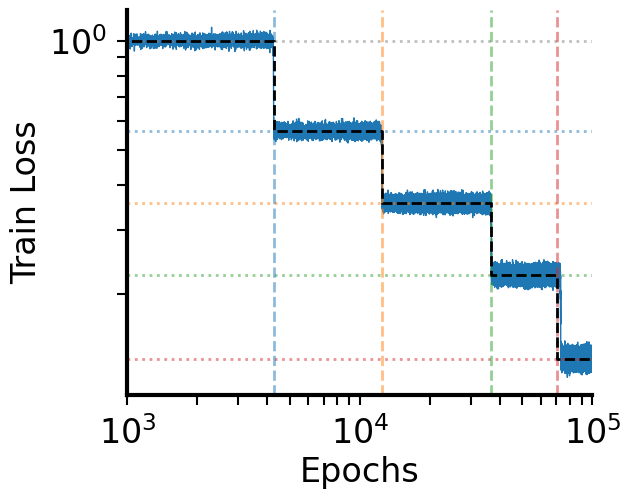

In [117]:
# Plot loss vs. epochs
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(loss_list, label='Online Gradient Descent', linewidth=1)
color_map = plt.get_cmap(name='tab10')

# Labels and title
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Train Loss", fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')



# Loss levels (horizontal lines)
for i, loss in enumerate(levels):
    color = "grey" if i == 0 else color_map(i - 1)
    ax.axhline(y=loss/2, color=color, alpha=0.5, linestyle='dotted', linewidth=2)

# Jump times (vertical lines)
taus = t_list
for i, tau in enumerate(taus):
    ax.axvline(x=tau, color=color_map(i), alpha=0.5, linestyle='dashed', linewidth=2)

# Levels and Jumps (step line)
maxepoch = taus[-1]
t_steps = [0] + [tau for tau in taus] + [100001]
l_steps =  [loss/2 for loss in levels] + [levels[-1]/2]
ax.step(t_steps, l_steps, where='post', color='k', linestyle='--', lw=2, label='AGF Theory')

ax.set_xlim(1000,100000)

# Style the axes
style_axes(ax)
#turn_off_grid
ax.grid(False)
# ax.legend(fontsize=20)
plt.savefig("loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [110]:
svalue_history=[]
for i in tqdm(range(len(model_list))):
    v,q,k=model_list[i]
    vbar=v[:,-1,-1][:,None,None]
    qbar=q[:,:,:D]
    kbar=k[:,:,:D]
    u,s,v=torch.linalg.svd((vbar*torch.bmm(kbar.transpose(1,2),qbar)).sum(axis=0))
    #figuring out the order
    innerproduct=(u.T@Q).abs()
    order_list=[]
    for i in range(len(innerproduct)):
        order_list.append(innerproduct[i].argmax())
    order_list=torch.tensor(order_list)
    s=s[order_list]
    
    svalue_history.append(s)
svalue_history=torch.stack(svalue_history)

100%|██████████| 100000/100000 [00:19<00:00, 5088.31it/s]


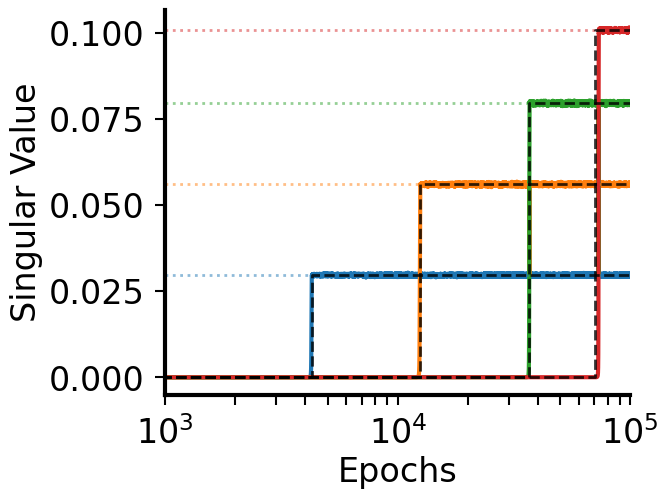

In [116]:

# Plot loss vs. epochs
fig, ax = plt.subplots(figsize=(6, 5))
color_map = plt.get_cmap(name='tab10')

singular_values = np.array(svalue_history)
for i in range(singular_values.shape[1]):
    ax.plot(singular_values[:,i], label='Singular Value {}'.format(i), linewidth=3)

# Labels and title
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Singular Value", fontsize=24)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(1e-6, loss_history[0] * 2)

# Get Jump times
taus = t_list
t_steps = [tau for tau in taus]


# Get Singular values of betas
singular_values_theory = 1/(eigenvalues.sum()+(N+1)*eigenvalues)

# Plot times x singular values (step lines)
max_time=1e5
for k in range(len(singular_values_theory)):
    t_steps=[0,taus[k],taus[k], max_time]
    s_steps=[0,0,singular_values_theory[k],singular_values_theory[k]]
    ax.step(t_steps, s_steps, where='post', linestyle='--', lw=2, color='k', zorder=10, alpha=0.8)

# Plot final singular values (horizontal lines)
for i, sval in enumerate(singular_values_theory):
    ax.axhline(y=sval, color=color_map(i), alpha=0.5, linestyle='dotted', linewidth=2)

# Style the axes
style_axes(ax)
ax.set_xlim(1000,100000)
# ax.legend(fontsize=20)
#turn_off_grid
ax.grid(False)
plt.savefig("singular-values.pdf", format="pdf", bbox_inches="tight")
plt.show()